In [1]:
# Import required packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

In [2]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import keras
import time
import pandas as pd
import time as time

## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [4]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'../data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('../data/noisy_labels.csv', delimiter=',', dtype="int8")

For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset. 

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


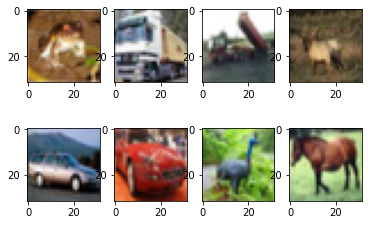

In [5]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))


## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [6]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [7]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [8]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

### 2.2. Model I

In [9]:
X_train = tf.cast(imgs, dtype='float32')/255.0
y_train = tf.one_hot(noisy_labels, depth=10)

In [10]:
# [BUILD A MORE SOPHISTICATED PREDICTIVE MODEL]

def model1():
    
    start_time = time.time()
    
    # build CNN
    modelI = tf.keras.Sequential([
        # First do feature extraction, every convolution and maxpooling works as a layer
        #Creates a convolution kernel with kernel size 32 and strides (3,3), use padding = "same" so input is half padded
        tf.keras.layers.Conv2D(32,(3,3),padding='same', activation ='relu', input_shape=(32,32,3)),
        #(2, 2) will take the max value over a 2x2 pooling window
        tf.keras.layers.MaxPooling2D((2,2)),
        #Drop out function drops out part of the data to prevent overfitting
        tf.keras.layers.Dropout(0.3),
        
        #Creates a convolution kernel with kernel size 64 and strides (3,3)
        tf.keras.layers.Conv2D(64,(3,3),padding='same', activation ='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Dropout(0.3),
        
        #Creates a convolution kernel with kernel size 96 and strides (3,3)
        tf.keras.layers.Conv2D(96, (3,3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Dropout(0.3),
        
        #Creates a convolution kernel with kernel size 64 and strides (3,3)
        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        
        #from here we have a dense network and start do classification
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dropout(0.3),
    
        tf.keras.layers.Dense(10, activation = 'softmax')        
                                ])
        
    modelI.compile(optimizer = tf.keras.optimizers.Adam(0.001),
                 #categoricalCrossentropy here decides that CNN is used
                 loss = tf.keras.losses.CategoricalCrossentropy(),
                 metrics = ['accuracy'])
    
    early_stop = tf.keras.callbacks.EarlyStopping(patience=3)

    class TimeHistory(keras.callbacks.Callback):
        def on_train_begin(self, logs={}):
            self.times = []

        def on_epoch_begin(self, epoch, logs={}):
            self.epoch_time_start = time.time()

        def on_epoch_end(self, epoch, logs={}):
            self.times.append(time.time() - self.epoch_time_start)

    time_callback = TimeHistory()
    
    modelI.fit(X_train, y_train, batch_size= 128, epochs=10,
          validation_split= 0.2, callbacks=[early_stop, time_callback])
    
    print("--- model took %s seconds ---" % (time.time() - start_time))
    
    return(modelI)

In [11]:
modelI = model1()

Epoch 1/10
313/313 [==============================] - 31s 98ms/step - loss: 2.2978 - accuracy: 0.1149 - val_loss: 2.2816 - val_accuracy: 0.1410
Epoch 2/10
313/313 [==============================] - 29s 93ms/step - loss: 2.2702 - accuracy: 0.1553 - val_loss: 2.2558 - val_accuracy: 0.1764
Epoch 3/10
313/313 [==============================] - 37s 118ms/step - loss: 2.2579 - accuracy: 0.1711 - val_loss: 2.2403 - val_accuracy: 0.1949
Epoch 4/10
313/313 [==============================] - 29s 93ms/step - loss: 2.2461 - accuracy: 0.1825 - val_loss: 2.2380 - val_accuracy: 0.1946
Epoch 5/10
313/313 [==============================] - 30s 96ms/step - loss: 2.2366 - accuracy: 0.1919 - val_loss: 2.2360 - val_accuracy: 0.1949
Epoch 6/10
313/313 [==============================] - 29s 94ms/step - loss: 2.2304 - accuracy: 0.1993 - val_loss: 2.2155 - val_accuracy: 0.2135
Epoch 7/10
313/313 [==============================] - 28s 91ms/step - loss: 2.2207 - accuracy: 0.2088 - val_loss: 2.2225 - val_accuracy

In [12]:
def model_I(image):
    prelabel = modelI.predict(image[np.newaxis,...])
    maxlabel = np.argmax(prelabel)
    return(maxlabel)

### 2.3. Model II

In [15]:
# [ADD WEAKLY SUPERVISED LEARNING FEATURE TO MODEL I]

# write your code here...

def model_II(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    # write your code here...

For Model II, we basically reproduced the method proposed from paper "Learning From Noisy Large-Scale Datasets With Minimal Supervision" (Andreas Veit et al). The main idea is to correct the noisy label

In [18]:
import time
from tqdm import tqdm, trange

In [22]:
y_pred = []
for i in trange(0:10000):
    y_pred.append(modelI.predict(imgs[i][np.newaxis,...])[0])
y_pred

100%|██████████| 10000/10000 [05:25<00:00, 30.70it/s]


[array([2.8839285e-17, 1.4536791e-19, 3.0454862e-19, 8.6690058e-18,
        6.0971735e-18, 8.2670509e-15, 2.5509746e-19, 9.9999607e-01,
        1.0939895e-17, 3.9024267e-06], dtype=float32),
 array([1.4732812e-16, 4.3521013e-11, 1.2762699e-15, 6.6884493e-12,
        8.5070411e-17, 1.8860476e-10, 3.1857460e-16, 8.3611656e-18,
        5.5582115e-07, 9.9999940e-01], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32),
 array([6.9556575e-07, 7.3044667e-08, 2.7390354e-07, 5.0105719e-08,
        4.3097176e-10, 2.0298140e-07, 2.5543066e-02, 8.5329461e-01,
        1.7957533e-09, 1.2116109e-01], dtype=float32),
 array([9.7639946e-30, 1.0343010e-07, 0.0000000e+00, 0.0000000e+00,
        3.3566049e-37, 4.6785107e-38, 0.0000000e+00, 5.9909134e-32,
        2.6617600e-32, 9.9999988e-01], dtype=float32),
 array([1.0431471e-14, 9.8933144e-17, 1.3641429e-21, 2.0320365e-13,
        3.6993022e-17, 6.1275484e-03, 7.8589435e-20, 5.3954084e-04,
        5.0048761e-18, 9.9333292e-0

In [23]:
y_noisy = tf.one_hot(noisy_labels[0:10000],depth = 10).numpy()
y_noisy

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [176]:
y_comb = []
for i in range(10000):
    y_comb.append([])
for i in range(10):
    for j in range(10000):
        if y_pred[j][i] > y_noisy[j][i]:
            y_comb[j].append(y_pred[j][i])
        else:
            y_comb[j].append(y_noisy[j][i]) 
y_comb = np.array(y_comb)

for i in range(10000):
    y_comb[i] = np.exp(y_comb[i])/sum(np.exp(y_comb[i]))
y_comb

array([[0.07442383, 0.07442383, 0.07442383, ..., 0.20230414, 0.07442383,
        0.07442412],
       [0.0744238 , 0.0744238 , 0.0744238 , ..., 0.0744238 , 0.07442384,
        0.20230474],
       [0.08533674, 0.08533674, 0.08533674, ..., 0.08533674, 0.08533674,
        0.23196933],
       ...,
       [0.07445286, 0.0746813 , 0.20238388, ..., 0.07445286, 0.07445286,
        0.20176479],
       [0.07582508, 0.09057973, 0.07582499, ..., 0.07582501, 0.07582702,
        0.17252949],
       [0.07444835, 0.07444628, 0.202366  , ..., 0.20188712, 0.07444628,
        0.07444628]], dtype=float32)

In [168]:
y_comb[0]

array([2.8839285e-17, 1.4536791e-19, 3.0454862e-19, 1.0000000e+00,
       6.0971735e-18, 8.2670509e-15, 2.5509746e-19, 9.9999607e-01,
       1.0939895e-17, 3.9024267e-06], dtype=float32)

In [169]:
y_true = tf.one_hot(clean_labels,depth = 10).numpy()
y_true

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [185]:
label_correction = tf.keras.Sequential([
 tf.keras.layers.Dense(10, activation = "linear"),
 tf.keras.layers.Dense(10,  activation = "relu"),
    tf.keras.layers.BatchNormalization(),
 tf.keras.layers.Dense(10, activation = "linear"),

 tf.keras.layers.Dense(10, activation = 'softmax')
])
label_correction.compile(
    optimizer='adam',
    loss = 'MeanAbsoluteError',
    metrics = ['accuracy']
)
label_correction.fit(y_comb, y_true, epochs=10)

Epoch 1/10
313/313 [==============================] - 1s 1ms/step - loss: 0.1585 - accuracy: 0.2716
Epoch 2/10
313/313 [==============================] - 0s 953us/step - loss: 0.1336 - accuracy: 0.3652
Epoch 3/10
313/313 [==============================] - 0s 1ms/step - loss: 0.1246 - accuracy: 0.3911
Epoch 4/10
313/313 [==============================] - 0s 973us/step - loss: 0.1194 - accuracy: 0.4187
Epoch 5/10
313/313 [==============================] - 0s 926us/step - loss: 0.1146 - accuracy: 0.4389
Epoch 6/10
313/313 [==============================] - 0s 887us/step - loss: 0.1135 - accuracy: 0.4393
Epoch 7/10
313/313 [==============================] - 0s 906us/step - loss: 0.1126 - accuracy: 0.4431
Epoch 8/10
313/313 [==============================] - 0s 892us/step - loss: 0.1125 - accuracy: 0.4416
Epoch 9/10
313/313 [==============================] - 0s 890us/step - loss: 0.1121 - accuracy: 0.4437
Epoch 10/10
313/313 [==============================] - 0s 902us/step - loss: 0.1120 - 

In [120]:
y_noisyall = tf.one_hot(noisy_labels,depth = 10).numpy()
y_noisyall

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [41]:
y_predall = []
for i in trange(n_img):
    y_predall.append(modelI.predict(imgs[i][np.newaxis,...])[0])
y_predall

100%|██████████| 50000/50000 [29:07<00:00, 28.62it/s]  


[array([2.8839285e-17, 1.4536791e-19, 3.0454862e-19, 8.6690058e-18,
        6.0971735e-18, 8.2670509e-15, 2.5509746e-19, 9.9999607e-01,
        1.0939895e-17, 3.9024267e-06], dtype=float32),
 array([1.4732812e-16, 4.3521013e-11, 1.2762699e-15, 6.6884493e-12,
        8.5070411e-17, 1.8860476e-10, 3.1857460e-16, 8.3611656e-18,
        5.5582115e-07, 9.9999940e-01], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32),
 array([6.9556575e-07, 7.3044667e-08, 2.7390354e-07, 5.0105719e-08,
        4.3097176e-10, 2.0298140e-07, 2.5543066e-02, 8.5329461e-01,
        1.7957533e-09, 1.2116109e-01], dtype=float32),
 array([9.7639946e-30, 1.0343010e-07, 0.0000000e+00, 0.0000000e+00,
        3.3566049e-37, 4.6785107e-38, 0.0000000e+00, 5.9909134e-32,
        2.6617600e-32, 9.9999988e-01], dtype=float32),
 array([1.0431471e-14, 9.8933144e-17, 1.3641429e-21, 2.0320365e-13,
        3.6993022e-17, 6.1275484e-03, 7.8589435e-20, 5.3954084e-04,
        5.0048761e-18, 9.9333292e-0

In [186]:
y_comball = []
for i in range(50000):
    y_comball.append([])
for i in range(10):
    for j in range(50000):
        if y_predall[j][i] > y_noisyall[j][i]:
            y_comball[j].append(y_predall[j][i])
        else:
            y_comball[j].append(y_noisyall[j][i])
y_comball = np.array(y_comball)

for i in range(50000):
    y_comball[i] = np.exp(y_comball[i])/sum(np.exp(y_comball[i]))
y_comball

array([[0.07442383, 0.07442383, 0.07442383, ..., 0.20230414, 0.07442383,
        0.07442412],
       [0.0744238 , 0.0744238 , 0.0744238 , ..., 0.0744238 , 0.07442384,
        0.20230474],
       [0.08533674, 0.08533674, 0.08533674, ..., 0.08533674, 0.08533674,
        0.23196933],
       ...,
       [0.08533674, 0.08533674, 0.08533674, ..., 0.08533674, 0.08533674,
        0.23196933],
       [0.07442885, 0.20231861, 0.07442885, ..., 0.07442885, 0.20225027,
        0.07442918],
       [0.07442379, 0.20230485, 0.07442379, ..., 0.07442379, 0.07442379,
        0.20230485]], dtype=float32)

In [187]:
corrlabel = label_correction.predict(y_comball)

In [188]:
# [BUILD A MORE SOPHISTICATED PREDICTIVE MODEL]

def model2():
    
    start_time = time.time()
    
    # build CNN
    modelII = tf.keras.Sequential([
        # First do feature extraction, every convolution and maxpooling works as a layer
        #Creates a convolution kernel with kernel size 32 and strides (3,3), use padding = "same" so input is half padded
        tf.keras.layers.Conv2D(32,(3,3),padding='same', activation ='relu', input_shape=(32,32,3)),
        #(2, 2) will take the max value over a 2x2 pooling window
        tf.keras.layers.MaxPooling2D((2,2)),
        #Drop out function drops out part of the data to prevent overfitting
        tf.keras.layers.Dropout(0.3),
        
        #Creates a convolution kernel with kernel size 64 and strides (3,3)
        tf.keras.layers.Conv2D(64,(3,3),padding='same', activation ='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Dropout(0.3),
        
        #Creates a convolution kernel with kernel size 96 and strides (3,3)
        tf.keras.layers.Conv2D(96, (3,3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Dropout(0.3),
        
        #Creates a convolution kernel with kernel size 64 and strides (3,3)
        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        
        #from here we have a dense network and start do classification
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dropout(0.3),
    
        tf.keras.layers.Dense(10, activation = 'softmax')        
                                ])
        
    modelII.compile(optimizer = tf.keras.optimizers.Adam(0.001),
                 #categoricalCrossentropy here decides that CNN is used
                 loss = tf.keras.losses.CategoricalCrossentropy(),
                 metrics = ['accuracy'])
    
    early_stop = tf.keras.callbacks.EarlyStopping(patience=3)

    class TimeHistory(keras.callbacks.Callback):
        def on_train_begin(self, logs={}):
            self.times = []

        def on_epoch_begin(self, epoch, logs={}):
            self.epoch_time_start = time.time()

        def on_epoch_end(self, epoch, logs={}):
            self.times.append(time.time() - self.epoch_time_start)

    time_callback = TimeHistory()
    
    modelII.fit(X_train, corrlabel, batch_size= 128, epochs=10,
          validation_split= 0.2, callbacks=[early_stop, time_callback])
    
    print("--- model took %s seconds ---" % (time.time() - start_time))
    
    return(modelII)

In [189]:
modelII = model2()

Epoch 1/10
313/313 [==============================] - 29s 92ms/step - loss: 2.1308 - accuracy: 0.2326 - val_loss: 1.9962 - val_accuracy: 0.3162
Epoch 2/10
313/313 [==============================] - 29s 92ms/step - loss: 1.9920 - accuracy: 0.3105 - val_loss: 1.9164 - val_accuracy: 0.3536
Epoch 3/10
313/313 [==============================] - 30s 96ms/step - loss: 1.9382 - accuracy: 0.3352 - val_loss: 1.8885 - val_accuracy: 0.3593
Epoch 4/10
313/313 [==============================] - 29s 93ms/step - loss: 1.9133 - accuracy: 0.3469 - val_loss: 1.8781 - val_accuracy: 0.3682
Epoch 5/10
313/313 [==============================] - 29s 93ms/step - loss: 1.8933 - accuracy: 0.3567 - val_loss: 1.8536 - val_accuracy: 0.3700
Epoch 6/10
313/313 [==============================] - 29s 91ms/step - loss: 1.8820 - accuracy: 0.3595 - val_loss: 1.8534 - val_accuracy: 0.3730
Epoch 7/10
313/313 [==============================] - 28s 90ms/step - loss: 1.8725 - accuracy: 0.3650 - val_loss: 1.8470 - val_accuracy:

In [ ]:
# 0.49

In [182]:
def model_II(image):
    prelabel = modelII.predict(image[np.newaxis,...])
    maxlabel = np.argmax(prelabel)
    return(maxlabel)

## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [13]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [14]:
X_test = imgs[0:10000]

In [15]:
evaluation(baseline_model, clean_labels, X_test)

              precision    recall  f1-score   support

           0       0.32      0.43      0.37      1005
           1       0.18      0.29      0.22       974
           2       0.22      0.04      0.07      1032
           3       0.19      0.12      0.14      1016
           4       0.24      0.48      0.32       999
           5       0.22      0.13      0.16       937
           6       0.26      0.35      0.30      1030
           7       0.29      0.04      0.07      1001
           8       0.28      0.43      0.34      1025
           9       0.19      0.11      0.14       981

    accuracy                           0.24     10000
   macro avg       0.24      0.24      0.21     10000
weighted avg       0.24      0.24      0.21     10000



In [16]:
evaluation(model_I, clean_labels, X_test)

              precision    recall  f1-score   support

           0       0.34      0.63      0.44      1005
           1       0.51      0.50      0.50       974
           2       0.43      0.08      0.14      1032
           3       0.37      0.03      0.05      1016
           4       0.55      0.02      0.03       999
           5       0.31      0.30      0.31       937
           6       0.36      0.27      0.31      1030
           7       0.28      0.71      0.40      1001
           8       0.70      0.31      0.43      1025
           9       0.32      0.71      0.44       981

    accuracy                           0.35     10000
   macro avg       0.42      0.36      0.31     10000
weighted avg       0.42      0.35      0.30     10000



In [190]:
evaluation(model_II, clean_labels, X_test)

              precision    recall  f1-score   support

           0       0.38      0.59      0.46      1005
           1       0.49      0.70      0.58       974
           2       0.40      0.13      0.20      1032
           3       0.31      0.09      0.13      1016
           4       0.48      0.02      0.04       999
           5       0.38      0.24      0.30       937
           6       0.44      0.37      0.40      1030
           7       0.29      0.73      0.41      1001
           8       0.67      0.49      0.57      1025
           9       0.36      0.61      0.46       981

    accuracy                           0.40     10000
   macro avg       0.42      0.40      0.36     10000
weighted avg       0.42      0.40      0.35     10000



In [ ]:
# 0.33

In [10]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(baseline_model, test_labels, test_imgs)

              precision    recall  f1-score   support

           0       0.33      0.46      0.38      1000
           1       0.21      0.31      0.25      1000
           2       0.20      0.04      0.07      1000
           3       0.19      0.12      0.14      1000
           4       0.24      0.48      0.32      1000
           5       0.20      0.11      0.14      1000
           6       0.24      0.34      0.28      1000
           7       0.31      0.04      0.08      1000
           8       0.27      0.43      0.33      1000
           9       0.20      0.12      0.15      1000

    accuracy                           0.24     10000
   macro avg       0.24      0.24      0.21     10000
weighted avg       0.24      0.24      0.21     10000



The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.

## 4. Prediction on the test data

In [ ]:
# load the test images
n_testimg = 10000
testimgs = np.empty((n_testimg,32,32,3))
for i in range(n_testimg):
    testimg_fn = f'../data/images/test{i+1:05d}.png'
    testimgs[i,:,:,:]=cv2.cvtColor(cv2.imread(testimg_fn),cv2.COLOR_BGR2RGB)

In [ ]:
index = array(range(1:10001))
Baseline = []
Model__I = []
Model__II = []

Baseline = baseline_model(testimgs)
Model__I = model_I(testimgs)
Model__II = model_II(testimgs)
output = pd.DataFrame('Index':index, 'Baseline':Baseline, 'ModelI':Model__I, 'ModelII':Model__II)
output.to_csv("../label_prediction.csv")